# MWC 22 - Data Science
**Author**: Carlos Pérez Ricardo

**email**: carlos.peri.1997@gmail.com

The aim of this notebook is to develop an analysis of a dataset from Nuwefruit. Nuwefruit is a startup that seeks to revolutionize the habits of the population by promoting the consumption of fruit on a daily basis by selling more than 20 types of fruit.

In the first part of the notebook an exploratoty analysis of the data was performed. It enabled to:
- Analyse the sales and the activity of clients
- Evaluate the impact of the promotion

And the second part, consisted on developing a predictive model that enables to know the type of segement each client belongs to as a function of the predictive variables. Download test_x. (The aim is to predict the variable: CLIENT_SEGMENT).

The final model achieves a macro F1-score in train:  and in test: . The result could be low but I think the problems lays on the generation of attributes not so much on the complexity of the model. In the last part, we may discuss which further steps could be performed to try to get a better score.

In [1]:
!pip install lightgbm
!pip install -U imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import scipy
import os
import pickle

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import sklearn.preprocessing as pp
from imblearn.over_sampling import SMOTE
from collections import Counter

# Models
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score 

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Hypothesis testing
from scipy import stats
from statsmodels.stats import weightstats as stests

import warnings
warnings.filterwarnings('ignore')

random_state=42

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
DIR = '/content'
TARGET = 'CLIENT_SEGMENT'

save_model = False
plot = False
knn_imputing = True
include_pca_to_rf = False
include_orders_similarity = False

# Clients

The dataset clients contains clients information such as:
- **CLIENT ID**: Unique client identifier 
- **CLIENT SEGMENT**: Client segment
- **AVG CONSO**: Monthly average consumption (in pieces of fruits) calculated in late 2020 
- **AVG BASKET SIZE**: Average Basket size calculated in late 2020
- **RECEIVED_COMMUNICATION**: 1= Received promotion of their products / 0= Not Received 

In [4]:
clients_df = pd.read_csv(os.path.join(DIR, 'mwc22-client_table.csv'))

# We correct commas to points as decimals
for col in clients_df.columns:
    try:
        clients_df[col] = clients_df[col].astype(np.float)
    except:
        clients_df[col] = clients_df[col].str.replace(',','.')
        clients_df[col] = clients_df[col].astype(float)

In [5]:
clients_df.head()

,CLIENT ID,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
0,24321771.0,6.0,67.25,201.75,0.0
1,24321859.0,2.0,58.33,350.00,0.0
2,24321880.0,3.0,46.67,112.00,0.0
3,24321957.0,2.0,50.00,600.00,0.0
4,24321962.0,4.0,10.00,120.00,0.0


## Client Segment

The number of clients is different across each segment. The customer segment with the most number of clients is 3. At first sight, there is no imbalanced class (is to be said a class which is minoritary). Even though, if we finally compute a model for each class, we would find an unbalanced dataset. 

In [6]:
clients_df['CLIENT_SEGMENT'].value_counts()

3.0    8123
4.0    7927
2.0    6760
1.0    6505
5.0    3429
6.0    3140
Name: CLIENT_SEGMENT, dtype: int64

In [7]:
clients_df.describe()

,CLIENT ID,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
count,3.588400e+04,35884.000000,35884.000000,35884.000000,35884.000000
mean,2.706058e+07,3.123593,64.534437,181.218610,0.507998
std,8.835076e+06,1.512932,64.381932,129.604691,0.499943
min,1.807311e+07,1.000000,0.830000,10.000000,0.000000
25%,2.053311e+07,2.000000,20.830000,100.000000,0.000000
50%,2.462190e+07,3.000000,50.000000,160.000000,1.000000
75%,3.298538e+07,4.000000,88.170000,225.000000,1.000000
max,4.836594e+07,6.000000,2433.330000,3400.200000,1.000000


## Distribution of Consumption and Basket Size across every Client Segment

In this part, an analysis of the variables (AVG CONSO and AVG BASKET SIZE) is performed considering the different customer segments. In the last part, a study of the impact of Receiving a communication is performed.

As there are outliers in both (AVG CONSO and AVG BASKET SIZE), we will limit the maximum values.

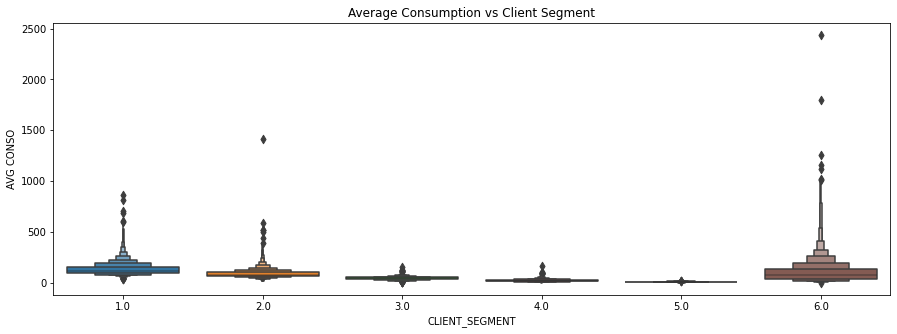

In [8]:
plt.figure(figsize=(15, 5))
ax = sns.boxenplot(data = clients_df, y='AVG CONSO', x='CLIENT_SEGMENT')
ax.set_title('Average Consumption vs Client Segment')
plt.show()

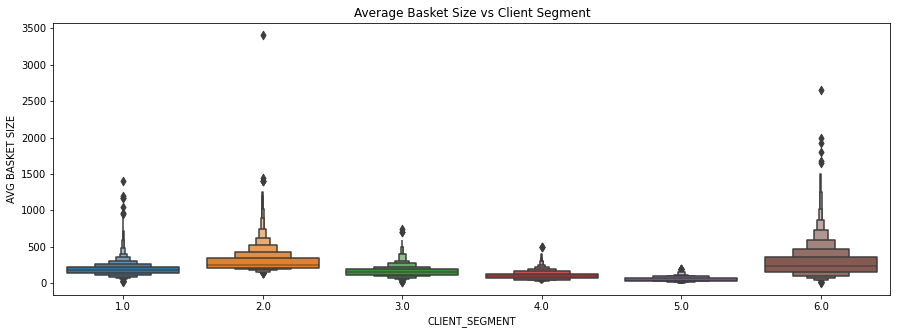

In [9]:
plt.figure(figsize=(15, 5))
ax = sns.boxenplot(data = clients_df, y='AVG BASKET SIZE', x='CLIENT_SEGMENT')
ax.set_title('Average Basket Size vs Client Segment')
plt.show()

We will clip for the purpose of data visualisation, firstly AVG CONSO to a maximum value of 1200 and AVG BASKET SIZE would be limited to 1500.

In [10]:
clients_df_ = clients_df.copy(deep=True)
clients_df_['AVG CONSO'] = np.clip(clients_df_['AVG CONSO'], a_max=1200, a_min=0)
clients_df_['AVG BASKET SIZE'] = np.clip(clients_df_['AVG BASKET SIZE'], a_max=1500, a_min=0)

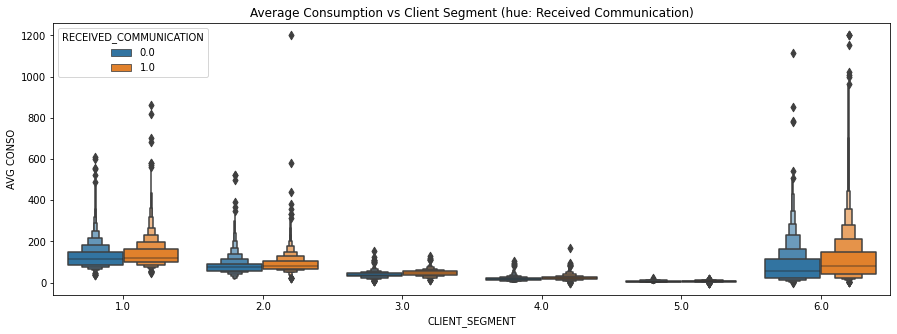

In [11]:
plt.figure(figsize=(15, 5))
ax = sns.boxenplot(data = clients_df_, y='AVG CONSO', x='CLIENT_SEGMENT', hue='RECEIVED_COMMUNICATION')
ax.set_title('Average Consumption vs Client Segment (hue: Received Communication)')
plt.show()

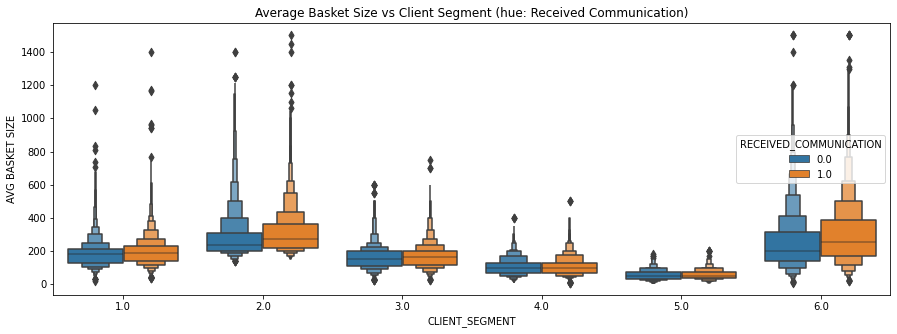

In [12]:
plt.figure(figsize=(15, 5))
ax = sns.boxenplot(data = clients_df_, y='AVG BASKET SIZE', x='CLIENT_SEGMENT', hue='RECEIVED_COMMUNICATION')
ax.set_title('Average Basket Size vs Client Segment (hue: Received Communication)')
plt.show()

### Impact of Received Communication

In this part an analysis of the parameter RECEIVED_COMMUNICATION and what impact it has to the variables: AVG CONSO and AVG BASKET SIZE.

In [13]:
clients_df.groupby(['RECEIVED_COMMUNICATION'])['AVG CONSO'].describe()

,count,mean,std,min,25%,50%,75%,max
RECEIVED_COMMUNICATION,,,,,,,,
0.0,17655.0,53.077870,55.637107,0.83,15.00,34.17,75.0,1116.67
1.0,18229.0,75.630256,70.082131,0.83,33.33,59.17,100.0,2433.33


In [14]:
clients_df.groupby(['RECEIVED_COMMUNICATION'])['AVG BASKET SIZE'].describe()

,count,mean,std,min,25%,50%,75%,max
RECEIVED_COMMUNICATION,,,,,,,,
0.0,17655.0,161.883020,119.440269,10.0,85.00,145.00,200.0,1675.0
1.0,18229.0,199.945355,136.151235,10.0,105.71,183.33,250.0,3400.2


Overall the impact of receiving a communication lead to better results both in the average consumption and the basket size. In general terms, the impact is an increase of the 74% in the average consumption (59/34-1) and an increase of the 26% in the basket size (183/45-1). 

We are evaluating the impact considering the medians because metrics like the mean are prone to being affected by outliers. 

In [15]:
clients_df.groupby(['CLIENT_SEGMENT','RECEIVED_COMMUNICATION'])['AVG CONSO'].describe()

count        mean  ...      75%      max
CLIENT_SEGMENT RECEIVED_COMMUNICATION                      ...                  
1.0            0.0                     2723.0  126.054444  ...  150.000   608.33
               1.0                     3782.0  136.760085  ...  161.670   862.58
2.0            0.0                     2960.0   81.468848  ...   92.250   520.83
               1.0                     3800.0   91.949345  ...  104.170  1416.75
3.0            0.0                     3699.0   39.077983  ...   47.250   151.67
               1.0                     4424.0   46.887681  ...   55.000   127.58
4.0            0.0                     4384.0   18.513125  ...   24.170   103.33
               1.0                     3543.0   23.781891  ...   30.000   166.75
5.0            0.0                     2577.0    6.361118  ...    8.330    20.83
               1.0                      852.0    7.324014  ...    9.170    19.17
6.0            0.0                     1312.0   84.292797  ...  116.670  1116.67
               1.0                     1828.0  117.122205  ...  150.205  2433.33

[12 rows x 8 columns]

In [16]:
clients_df.groupby(['CLIENT_SEGMENT','RECEIVED_COMMUNICATION'])['AVG BASKET SIZE'].describe()

count        mean  ...      75%      max
CLIENT_SEGMENT RECEIVED_COMMUNICATION                      ...                  
1.0            0.0                     2723.0  182.235835  ...  212.500  1201.17
               1.0                     3782.0  196.168850  ...  227.410  1400.00
2.0            0.0                     2960.0  282.845676  ...  310.000  1400.00
               1.0                     3800.0  310.864108  ...  360.775  3400.20
3.0            0.0                     3699.0  158.854117  ...  200.000   600.00
               1.0                     4424.0  167.572014  ...  200.000   750.00
4.0            0.0                     4384.0  104.909710  ...  130.000   400.00
               1.0                     3543.0  106.175083  ...  125.000   500.00
5.0            0.0                     2577.0   56.348514  ...   75.000   180.00
               1.0                      852.0   58.458603  ...   75.000   200.00
6.0            0.0                     1312.0  252.940290  ...  316.670  1675.00
               1.0                     1828.0  303.219934  ...  390.000  2654.55

[12 rows x 8 columns]

If we consider the impact across client segments, only in segments 4 and 5 we cannot observed any increase in both the average consumption and the basket size. In others segments, receiving a communication made customers to purchase more fruits. 

### Hypothesis testing

However, are these results significantly important. Does receiving a communication really makes you purchase more fruits? To check this, we can perform an hypothesis testing.

We would perform a Two-sample Z test- In two sample z-test we are checking two independent data groups and deciding whether sample mean of two group is equal or not.

In [17]:
overall_mean = clients_df_['AVG CONSO'].mean()

In [18]:
data1 = clients_df_[clients_df_['RECEIVED_COMMUNICATION']==0]['AVG CONSO']
data2 = clients_df_[clients_df_['RECEIVED_COMMUNICATION']==1]['AVG CONSO']

In [19]:
ztest ,pval1 = stests.ztest(data1, x2=data2, value=overall_mean, alternative='two-sided')
print(float(pval1))
if pval1<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

0.0
reject null hypothesis


This test says that we can reject the hypothesis that receiving a communication and not receiving does not affect the purchasing behaviour. So, receiving a communication improves purchasing behaviour indeed. 

# Orders

In [20]:
orders_df = pd.read_csv(os.path.join(DIR, 'mwc22-orders_table.csv'))

In [21]:
orders_df.head()

,CLIENT ID,NB PRODS,ORDER ID,FRUIT_PRODUCT
0,18070505,5,671907264,Apple
1,18070505,10,671907264,Orange
2,18070505,5,671907264,Kiwi
3,18070505,10,671907264,Pear
4,18070505,5,671907264,Cheery


In [22]:
orders_df.shape

(66912, 4)

In [23]:
orders_expanded = pd.pivot_table(orders_df, index='ORDER ID', columns='FRUIT_PRODUCT', values = 'NB PRODS', aggfunc=[sum], fill_value=0)
orders_expanded.columns = orders_expanded.columns.droplevel(0)

In [24]:
order_clients = orders_df[['CLIENT ID', 'ORDER ID']]

In [25]:
orders = pd.merge(order_clients, orders_expanded, on=['ORDER ID'], how='outer')

In [26]:
fruits = [col for col in orders.columns if col not in ['ORDER ID','CLIENT ID']]
fruits

['Apple',
 'Apricot',
 'Banana',
 'Blueberry',
 'Cheery',
 'Coconut',
 'Devil Fruit',
 'Grape',
 'Jackfruit',
 'Kiwi',
 'Lemon',
 'Lime',
 'Mango',
 'Melon',
 'Nectarine',
 'Nuwe Fruit',
 'Orange',
 'Papaya',
 'Pear',
 'Pineapple',
 'Plum',
 'Pomegranate',
 'Strawberry',
 'Watermelon']

In [27]:
#clients_orders_summary = orders.groupby('CLIENT ID').agg([np.min, np.mean, np.max, np.sum])
clients_orders_summary = orders.groupby('CLIENT ID').agg([np.mean])
clients_orders_summary.columns = ['_'.join(col).strip() for col in clients_orders_summary.columns.values]

# Drop ORDER ID columns
cols = [col for col in clients_orders_summary.columns if not str.__contains__(col,"ORDER ID")]

clients_orders_summary = clients_orders_summary[cols]
clients_orders_summary

if False:
    for fruit in fruits:
        for metric in ['amin','mean','amax','sum']:
            x = pd.cut(np.array(clients_orders_summary[fruit+'_'+metric]), bins=5)

            le = LabelEncoder()
            x_ = le.fit_transform(x)

            clients_orders_summary[fruit+'_'+metric] = x_

In [28]:
clients_summary = orders.groupby('CLIENT ID')['ORDER ID'].agg(['count'])
clients_summary.columns = ['n_orders']

clients_orders_summary = pd.concat([clients_orders_summary, clients_summary], axis=1)

In [29]:
items_df = orders.set_index('CLIENT ID')
items_df['n_items'] = items_df[fruits].sum(axis=1)
items_df = items_df[['n_items']]
items_df.reset_index(inplace=True)

items_df

items_summary = items_df.groupby('CLIENT ID')['n_items'].agg([np.mean, np.max, np.sum])
#items_summary = items_df.groupby('CLIENT ID')['n_items'].agg([np.mean])
items_summary.columns = 'n_items_' + items_summary.columns
items_summary.head()

,n_items_mean,n_items_amax,n_items_sum
CLIENT ID,,,
18070505,35.000000,35,175
18071016,50.000000,50,300
18071233,30.000000,30,240
18071668,13.714286,15,96
18072186,15.000000,15,30


## Similarity of orders among same client

For each client how is the distribution of orders he/she has made? Do they make similar orders (ordering the same products) or client changes their tastes or preferences often?

To implement the similarity we would use cosine similarity. This enables to compute the semblance between two orders (or vectors) a similarity of 1 indicates that the orders are equal (or parallel if we talk about vectors). 

We can implement the same with the fruits and see what is the similarity between the fruits.

To compute the cosine similarity efficiently using sparse matrices I followed this [post](http://na-o-ys.github.io/others/2015-11-07-sparse-vector-similarities.html)

In [30]:
len(fruits)

24

In [31]:
A = orders[fruits]
# Fruits categorised to bins
for fruit in fruits:
    x = pd.cut(np.array(A[fruit]), bins=5)

    le = LabelEncoder()
    x_ = le.fit_transform(x)

    A[fruit] = x_

In [32]:
def cosine_similarities(mat):
    col_normed_mat = pp.normalize(mat.tocsc(), axis=0)
    return col_normed_mat.T * col_normed_mat

fruits_similarities = cosine_similarities(scipy.sparse.csc_matrix(A))

fruits_similarities

<24x24 sparse matrix of type '<class 'numpy.float64'>'
	with 532 stored elements in Compressed Sparse Row format>

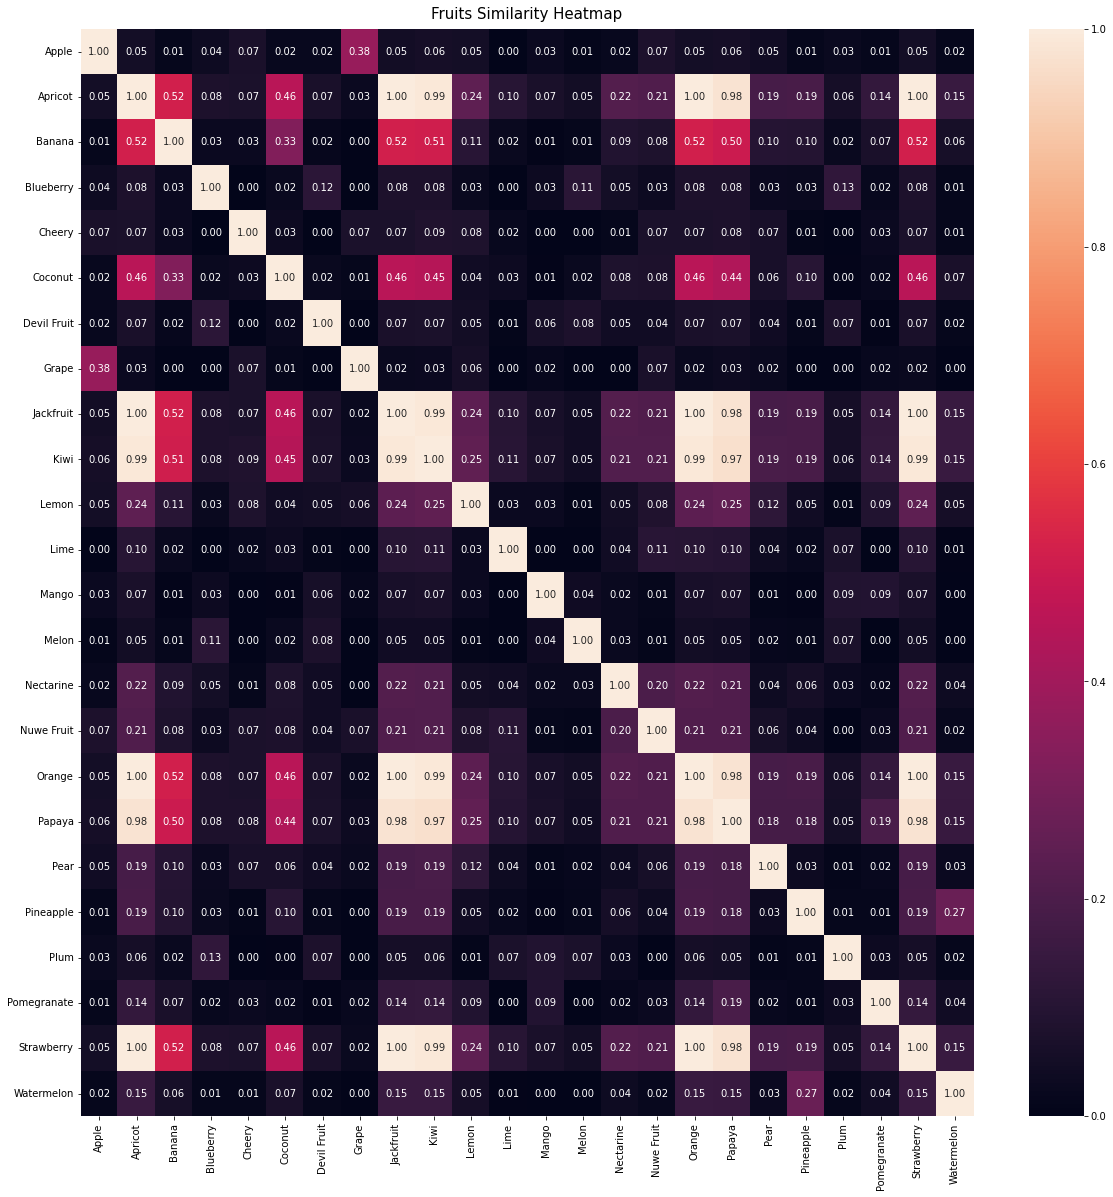

In [33]:
plt.figure(figsize=(20, 20))
fruits_matrix = pd.DataFrame(fruits_similarities.toarray(), index=fruits, columns=fruits)
heatmap = sns.heatmap(fruits_matrix, vmin=0, vmax=1, annot=True, fmt='.2f')
heatmap.set_title('Fruits Similarity Heatmap', fontdict={'fontsize':15}, pad=10);

The matrix above could help us to make recommendations to our customers. For instance, clients who ordered Strawberry would also like Jackfruit, Kiwi, Orange or Papaya because other clients have ordered before. 

In [34]:
clients_similarities_dict = {}

for client in orders['CLIENT ID'].unique():
    client_df = orders[ orders['CLIENT ID'] == client]
    client_df.drop(['CLIENT ID', 'ORDER ID'], axis=1, inplace=True)
    client_df = client_df.transpose()

    orders_similarities = cosine_similarities(scipy.sparse.csc_matrix(client_df))
    orders_similarities = pd.DataFrame(orders_similarities.toarray())

    a = np.array(orders_similarities)
    # Compute very similar orders a 1 others 0
    #a[a < 0.8] = 0 
    try:
        #clients_similarities_dict[client] = {'mean': a[np.triu_indices(3)].mean(),'min': a[np.triu_indices(3)].min(), 'max': a[np.triu_indices(3)].max()}
        clients_similarities_dict[client] = {'min': a[np.triu_indices(3)].min()}
    except:
        #clients_similarities_dict[client] = {'mean': 0,'min': 0, 'max': 0}
        clients_similarities_dict[client] = {'min': 0}

In [35]:
clients_similarities_df = pd.DataFrame(clients_similarities_dict)
clients_similarities_df = clients_similarities_df.transpose()
clients_similarities_df.columns = 'orders_sim_' + clients_similarities_df.columns
clients_similarities_df

,orders_sim_min
18070505,1.0
18071016,1.0
18071233,1.0
18071668,1.0
18072186,0.0
...,...
48331345,1.0
48331450,0.0
48341696,0.0
48341727,1.0


In [36]:
clients_orders_summary = pd.concat([clients_orders_summary, items_summary], axis=1)

if include_orders_similarity:
    clients_orders_summary = pd.concat([clients_orders_summary, clients_similarities_df], axis=1)

clients_orders_summary['CLIENT ID'] = clients_orders_summary.index
clients_orders_summary

,Apple_mean,Apricot_mean,Banana_mean,Blueberry_mean,Cheery_mean,Coconut_mean,Devil Fruit_mean,Grape_mean,Jackfruit_mean,Kiwi_mean,Lemon_mean,Lime_mean,Mango_mean,Melon_mean,Nectarine_mean,Nuwe Fruit_mean,Orange_mean,Papaya_mean,Pear_mean,Pineapple_mean,Plum_mean,Pomegranate_mean,Strawberry_mean,Watermelon_mean,n_orders,n_items_mean,n_items_amax,n_items_sum,CLIENT ID
CLIENT ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
18070505,5.0,0.0,0.0,0.000000,5.0,0.0,0.000000,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.000000,0.000000,10.000000,0.0,10.0,0.0,0.000000,0.0,0.0,0.0,5,35.000000,35,175,18070505
18071016,0.0,0.0,0.0,0.000000,15.0,0.0,0.000000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000000,0.000000,10.000000,0.0,0.0,0.0,0.000000,0.0,10.0,5.0,6,50.000000,50,300,18071016
18071233,3.0,0.0,0.0,3.000000,9.0,0.0,3.000000,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.000000,3.000000,0.000000,0.0,0.0,0.0,0.000000,3.0,0.0,0.0,8,30.000000,30,240,18071233
18071668,0.0,0.0,0.0,1.714286,0.0,0.0,1.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.285714,2.571429,1.714286,0.0,0.0,0.0,1.714286,0.0,0.0,0.0,7,13.714286,15,96,18071668
18072186,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.000000,0.000000,0.000000,5.0,0.0,0.0,0.000000,0.0,0.0,0.0,2,15.000000,15,30,18072186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48341696,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,6.666667,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3,6.666667,20,20,48341696
48341727,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,2.0,0.0,10.0,0.0,0.0,0.000000,4.000000,4.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,4,20.000000,20,80,48341727
48352045,1.0,1.0,0.0,0.000000,0.0,1.0,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,2.0,1.000000,0.0,0.0,2.0,8,10.000000,10,80,48352045


### Drop high correlated columns

In [37]:
if plot == True:
    plt.figure(figsize=(30, 20))

    heatmap = sns.heatmap(clients_orders_summary.corr(), vmin=-1, vmax=1, annot=True, fmt='.2f')

    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':1}, pad=5);

In [38]:
clients_orders_summary.columns

Index(['Apple_mean', 'Apricot_mean', 'Banana_mean', 'Blueberry_mean',
       'Cheery_mean', 'Coconut_mean', 'Devil Fruit_mean', 'Grape_mean',
       'Jackfruit_mean', 'Kiwi_mean', 'Lemon_mean', 'Lime_mean', 'Mango_mean',
       'Melon_mean', 'Nectarine_mean', 'Nuwe Fruit_mean', 'Orange_mean',
       'Papaya_mean', 'Pear_mean', 'Pineapple_mean', 'Plum_mean',
       'Pomegranate_mean', 'Strawberry_mean', 'Watermelon_mean', 'n_orders',
       'n_items_mean', 'n_items_amax', 'n_items_sum', 'CLIENT ID'],
      dtype='object')

There are columns with high correlation (> 0.98) we should only keep one. This high correlation can come from same products with different metrics (mean and max) or between same products (two products hadn't been bought).

We will discard these columns.

In [39]:
corr_matrix = clients_orders_summary.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features 
clients_orders_summary.drop(to_drop, axis=1, inplace=True)

In [40]:
if plot == True:
    plt.figure(figsize=(30, 20))

    heatmap = sns.heatmap(clients_orders_summary.corr(), vmin=-1, vmax=1, annot=True, fmt='.2f')

    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':1}, pad=5);

In [41]:
clients_orders_summary.columns

Index(['Apple_mean', 'Apricot_mean', 'Banana_mean', 'Blueberry_mean',
       'Cheery_mean', 'Coconut_mean', 'Devil Fruit_mean', 'Grape_mean',
       'Jackfruit_mean', 'Kiwi_mean', 'Lemon_mean', 'Lime_mean', 'Mango_mean',
       'Melon_mean', 'Nectarine_mean', 'Nuwe Fruit_mean', 'Orange_mean',
       'Papaya_mean', 'Pear_mean', 'Pineapple_mean', 'Plum_mean',
       'Pomegranate_mean', 'Strawberry_mean', 'Watermelon_mean', 'n_orders',
       'n_items_mean', 'n_items_sum', 'CLIENT ID'],
      dtype='object')

# Combine Orders info with Clients info

In [42]:
clients_orders_summary = clients_orders_summary.reset_index(drop=True)

In [43]:
all_df = pd.merge( clients_df, clients_orders_summary, on='CLIENT ID', how='outer')
all_df

,CLIENT ID,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION,Apple_mean,Apricot_mean,Banana_mean,Blueberry_mean,Cheery_mean,Coconut_mean,Devil Fruit_mean,Grape_mean,Jackfruit_mean,Kiwi_mean,Lemon_mean,Lime_mean,Mango_mean,Melon_mean,Nectarine_mean,Nuwe Fruit_mean,Orange_mean,Papaya_mean,Pear_mean,Pineapple_mean,Plum_mean,Pomegranate_mean,Strawberry_mean,Watermelon_mean,n_orders,n_items_mean,n_items_sum
0,24321771.0,6.0,67.25,201.75,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,2.000000,2.0
1,24321859.0,2.0,58.33,350.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24321880.0,3.0,46.67,112.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,10.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,10.000000,10.0
3,24321957.0,2.0,50.00,600.00,0.0,0.0,20.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,20.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.0,40.000000,80.0
4,24321962.0,4.0,10.00,120.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35886,18071233.0,NaN,NaN,NaN,NaN,3.0,0.0,0.0,3.000000,9.0,0.0,3.000000,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.000000,3.000000,0.000000,0.0,0.0,0.0,0.000000,3.0,0.0,0.0,8.0,30.000000,240.0
35887,18071668.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.714286,0.0,0.0,1.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.285714,2.571429,1.714286,0.0,0.0,0.0,1.714286,0.0,0.0,0.0,7.0,13.714286,96.0
35888,18072186.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.000000,0.000000,0.000000,5.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.0,15.000000,30.0
35889,18072741.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,5.000000,0.0,0.0,4.000000,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,3.0,0.000000,0.0,0.0,4.0,6.0,20.000000,120.0


There are clients in orders that are not in the client list. So we will not consider them.
And there are clients in the client list with no order history. 

In [44]:
all_df = all_df[ ~all_df['CLIENT_SEGMENT'].isnull() ]
all_df.set_index('CLIENT ID', inplace=True)
all_df.head()

,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION,Apple_mean,Apricot_mean,Banana_mean,Blueberry_mean,Cheery_mean,Coconut_mean,Devil Fruit_mean,Grape_mean,Jackfruit_mean,Kiwi_mean,Lemon_mean,Lime_mean,Mango_mean,Melon_mean,Nectarine_mean,Nuwe Fruit_mean,Orange_mean,Papaya_mean,Pear_mean,Pineapple_mean,Plum_mean,Pomegranate_mean,Strawberry_mean,Watermelon_mean,n_orders,n_items_mean,n_items_sum
CLIENT ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
24321771.0,6.0,67.25,201.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0
24321859.0,2.0,58.33,350.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24321880.0,3.0,46.67,112.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,10.0
24321957.0,2.0,50.00,600.00,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,40.0,80.0
24321962.0,4.0,10.00,120.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning

When we merge the clients data with the orders data, we have observed that there are some clients that do not have any orders data. In this case the order's columns are NaNs.

What do we do with this data?
- We can impute this data with a number.
- We can use a KNN Imputer to find out we will ask neighbours which values do they have and compute the mean across them. As performing the KNN of all the data will last ages, we would select a sample.

In this case we perform a KNN imputation. I am not really convinced of this approach, as for a single row or client with no orders data, we have to fill all the orders columns, so we are guessing a lot of data. Even though, this approach leads to better results for the prediction models. 

Note that we only use the training data to perform the KNNImputer. 

In [45]:
# To reduce high cardinality that affects feature importance
# What is the different between 1.5 and 1.7 in the average consumption? 
all_df['AVG CONSO'] = all_df['AVG CONSO'].astype(int)
all_df['AVG BASKET SIZE'] = all_df['AVG BASKET SIZE'].astype(int)

In [46]:
selected_cols = [col for col in all_df.columns if col != TARGET]
X = all_df[selected_cols]
y = all_df[TARGET]

if knn_imputing:
    from sklearn.impute import KNNImputer

    # Too long
    #X = pd.DataFrame(imputer.fit_transform(X), columns = selected_cols, index=all_df.index)

    imputer = KNNImputer(n_neighbors=3)
    imputer.fit(X.sample(10000))
    print('Fitting finished')
    X = pd.DataFrame(imputer.transform(X), columns = selected_cols, index=all_df.index)
    print('Transforming finished')
    
else:
    X = pd.DataFrame(X.fillna(-5))

Fitting finished
Transforming finished


In [47]:
if False:
    for col in ['AVG CONSO','AVG BASKET SIZE']:
        x = pd.cut(np.array(X[col]), bins=10)

        le = LabelEncoder()
        x_ = le.fit_transform(x)

        X[col+'_cat'] = x_

In [48]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=random_state)

n_classes = len(np.unique(y))

## Introducing group metrics

After running several models, we have observed that AVG CONSO and AVG BASKET SIZE are the predicitive features with the higher feature importance and the rest of features do not contribute as much.

So in order to help the model and get more insights from the fruits variables, we might introduce KMeans clustering among fruits variables and compute the mean and median of average consumption and average basket size.

In [49]:
# Pre clustering with KMeans

# We have to use only train!!!

cluster_cols = [ f+'_mean' for f in fruits]
pre_cluster = X_train[cluster_cols]

from sklearn.cluster import KMeans

km = KMeans(n_clusters=6)
km.fit(pre_cluster)
 
X_train['pre_cluster'] = km.predict(pre_cluster)
X_test['pre_cluster'] = km.predict(X_test[cluster_cols])

# Compute Mean and Median among the cluster

X_train['pre_cluster_AVG_CONSO_mean'] = X_train.groupby('pre_cluster')['AVG CONSO'].transform( lambda x: x.mean())
X_train['pre_cluster_AVG_CONSO_median'] = X_train.groupby('pre_cluster')['AVG CONSO'].transform( lambda x: x.median())
X_train['pre_cluster_AVG_BASKET_mean'] = X_train.groupby('pre_cluster')['AVG BASKET SIZE'].transform( lambda x: x.mean())

train_agg = X_train[['pre_cluster','pre_cluster_AVG_CONSO_mean','pre_cluster_AVG_CONSO_median','pre_cluster_AVG_BASKET_mean']].drop_duplicates()

X_test = pd.merge( X_test, train_agg, on = ['pre_cluster'], how='left')

# Prediction models

In this section we will build several prediction models in order to obtain the model that best predicts our target. Several approaches will be considered:
- **PCA-KNN:** We would perform a Principal Componenent Analysis (PCA) to reduce the number of features and later the model would be a K-Nearest Neighbours model.
- **LDA-KNN:** We would perform a Linear Discriminant Analysis (LDA) to reduce the number of features and later the model would be a K-Nearest Neighbours model.
- **Multiclass RF**: Multiclass Random Forest Classifier that predicts the client segment directly. A single model all the client segments (multiclass classification)
- **SMOTE - Multiclass RF**: As the number of clients in each client segment is different and from previous models we had obseved that the overall solution is taking care of all segments equally, we perform an oversample with Synthetic Minority Over-sampling Technique (SMOTE) and later a multiclass Random Forest Classifier model is trained. 
- **One for each - LGBM**: A Light Gradient Boosting model for each client segment is built (there are 6 models in total). Later, the model that predict 1 with the higher probability is selected. We would undersample the distribution for each model dataset.

The approach that provided the best results was **SMOTE - Multiclass RF**.

Other possibilities that could have been performed are:
- **SVM**: Support Vector Machines (however data should be normalised and columns combination (multiply x1*x2 would be advisable)- I would not expect better results, but who knows)
- **DBSCAN**: Similar to KNN (I would not expect better results, but who knows)
- **Neural Nets Multiclass Classifier**: This approach would have been tested if I had time. Several architectures would need to be tested. 
- **Stacked approach**: Rather than a single model solution, why not combine all models and obtain the average. It can be possible that one approach is really good at identifying cluster 6, and the other approaches are so good at it. So we could adquire the knowledge of every different approach.

## PCA-KNN

In [50]:
n_neighbors = 3

# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=30, random_state=random_state))

# Reduce dimension to 2 with LinearDiscriminantAnalysis
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=4))

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=3, random_state=random_state),
)

In [51]:
# Use a nearest neighbor classifier to evaluate the methods
pca_knn = KNeighborsClassifier(n_neighbors=4)

pca.fit(X_train, y_train)

# Fit a nearest neighbor classifier on the embedded training set
pca_knn.fit(pca.transform(X_train), y_train)
    
y_pred_train = pca_knn.predict(pca.transform(X_train))
y_pred_test = pca_knn.predict(pca.transform(X_test))
    
# Compute the nearest neighbor accuracy on the embedded test set
print('PCA')
print("TRAIN:", f1_score(y_train, y_pred_train, average='macro'))
print("TEST:", f1_score(y_test, y_pred_test, average='macro'))

PCA
TRAIN: 0.6386696619725202
TEST: 0.5465041474653732


## LDA-KNN

In [52]:
# Use a nearest neighbor classifier to evaluate the methods
lda_knn = KNeighborsClassifier(n_neighbors=n_neighbors)

lda.fit(X_train, y_train)

# Fit a nearest neighbor classifier on the embedded training set
lda_knn.fit(lda.transform(X_train), y_train)
    
y_pred_train = lda_knn.predict(lda.transform(X_train))
y_pred_test = lda_knn.predict(lda.transform(X_test))
    
# Compute the nearest neighbor accuracy on the embedded test set
print('LDA')
print("TRAIN:", f1_score(y_train, y_pred_train, average='macro'))
print("TEST:", f1_score(y_test, y_pred_test, average='macro'))

LDA
TRAIN: 0.7012172389190212
TEST: 0.6153182032148367


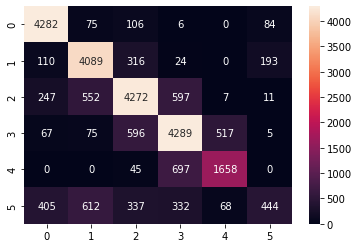

In [53]:
cf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cf_matrix, annot=True, fmt='.0f')

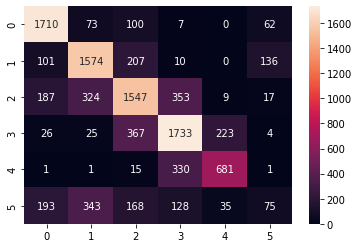

In [54]:
cf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf_matrix, annot=True, fmt='.0f')

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=random_state)

A possible approach would be to add the KNN predictions to the actual dataset. So we help the following model so it can focus on detecting client segments right where the previous model failed.

In [56]:
if include_pca_to_rf:
    X_train_ = X_train.copy(deep=True)
    X_test_ = X_test.copy(deep=True)

    X_train_['pca_knn'] = pca_knn.predict(pca.transform(X_train))
    X_test_['pca_knn'] = pca_knn.predict(pca.transform(X_test))

    X_train_['lda_knn'] = lda_knn.predict(lda.transform(X_train))
    X_test_['lda_knn'] = lda_knn.predict(lda.transform(X_test))

else:
    
    X_train_ = X_train.copy(deep=True)
    X_test_ = X_test.copy(deep=True)

## Multiclass RF

In [57]:
X_train = X_train_.copy(deep=True)
X_test = X_test_.copy(deep=True)

In [58]:
rf = RandomForestClassifier(n_estimators = 400, max_depth=60, min_samples_leaf=5, random_state=random_state)
rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("TRAIN:", f1_score(y_train, y_pred_train, average='macro'))
print("TEST:", f1_score(y_test, y_pred_test, average='macro'))

TRAIN: 0.7289552701561921
TEST: 0.6925946384644397


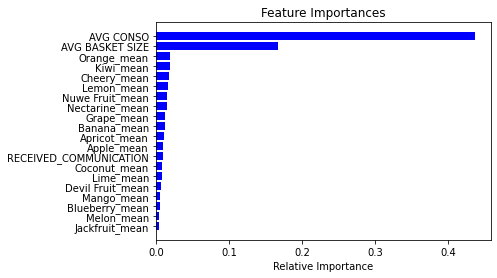

In [59]:
importances = rf.feature_importances_[:20]
indices = np.argsort(importances)
features = X_train.columns

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [60]:
rf = RandomForestClassifier(random_state=random_state)

param_dist = {"max_depth": [10, 20, 30, 50],
                  "n_estimators": [150, 250, 450, 550]
                 }
grid_search = GridSearchCV(rf, n_jobs=-1, param_grid=param_dist, cv = 5, scoring='f1_macro', verbose=10)
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
    
print(model)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("TRAIN:", f1_score(y_train, y_pred_train, average='macro'))
print("TEST:", f1_score(y_test, y_pred_test, average='macro'))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
RandomForestClassifier(max_depth=30, n_estimators=550, random_state=42)
TRAIN: 0.8497534639586162
TEST: 0.6946014900360383


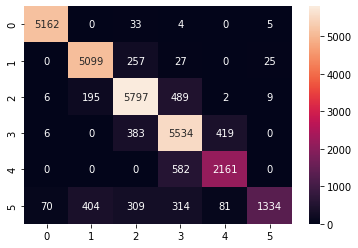

In [61]:
cf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cf_matrix, annot=True, fmt='.0f')

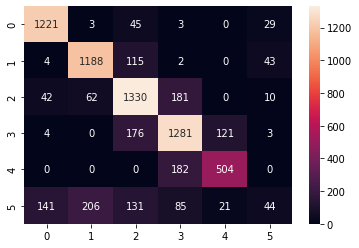

In [62]:
cf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf_matrix, annot=True, fmt='.0f')

## SMOTE - Multiclass RF

In [63]:
oversample = SMOTE()
X_train_ov, y_train_ov = oversample.fit_resample(X_train, y_train)

print('Before Sampling')
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

print('\n After Sampling')
counter = Counter(y_train_ov)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Before Sampling
Class=4, n=6342 (17.674%)
Class=2, n=5408 (15.071%)
Class=3, n=6498 (18.108%)
Class=5, n=2743 (7.644%)
Class=6, n=2512 (7.000%)
Class=1, n=5204 (14.502%)

 After Sampling
Class=4, n=6498 (18.108%)
Class=2, n=6498 (18.108%)
Class=3, n=6498 (18.108%)
Class=5, n=6498 (18.108%)
Class=6, n=6498 (18.108%)
Class=1, n=6498 (18.108%)


In [64]:
rf = RandomForestClassifier(random_state=random_state)

param_dist = {"max_depth": [20, 30, 35, 45, 50],
                  "n_estimators": [150, 200, 250, 300]
                 }
grid_search = GridSearchCV(rf, n_jobs=-1, param_grid=param_dist, cv = 5, scoring='f1_macro', verbose=20)
grid_search.fit(X_train_ov, y_train_ov)
smote_model = grid_search.best_estimator_
    
print(smote_model)
y_pred_train_ = smote_model.predict(X_train_ov)
y_pred_train = smote_model.predict(X_train)
y_pred_test = smote_model.predict(X_test)

print("TRAIN (oversample):", f1_score(y_train_ov, y_pred_train_, average='macro'))
print("TRAIN:", f1_score(y_train, y_pred_train, average='macro'))
print("TEST:", f1_score(y_test, y_pred_test, average='macro'))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomForestClassifier(max_depth=35, n_estimators=300, random_state=42)
TRAIN (oversample): 0.8716981400865637
TRAIN: 0.8422113939115558
TEST: 0.7000258684308882


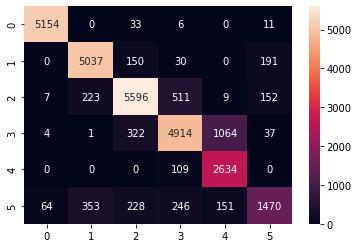

In [65]:
cf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cf_matrix, annot=True, fmt='.0f')

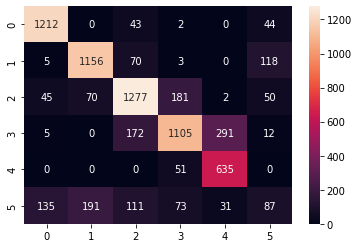

In [66]:
cf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf_matrix, annot=True, fmt='.0f')

In [67]:
if save_model:
    filename = 'oversample_model.sav'
    pickle.dump(smote_model, open(filename, 'wb'))

## One for each - LGBM

In [68]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state)

all_pred_train = pd.DataFrame()
all_pred_test = pd.DataFrame()

for segment in range(1,n_classes+1):
    print(segment)
    
    y_train_onehot = y_train.apply(lambda x:1 if x == segment else 0)
    y_test_onehot = y_test.apply(lambda x:1 if x == segment else 0)

    true = y_train_onehot.loc[ y_train_onehot == 1].index.to_list()
    non_true = y_train_onehot.loc[ y_train_onehot == 0].sample( round(len(true)*2) ).index.to_list()
    idx = true + non_true
    
    X_train_ = X_train.loc[idx]
    y_train_onehot_ = y_train_onehot.loc[idx]

    #oversample = SMOTE()
    #X_train_, y_train_onehot_ = oversample.fit_resample(X_train, y_train_onehot)
    
    lgtrain_ = lgb.Dataset(X_train_, label=y_train_onehot_)
    
    lg = lgb.LGBMClassifier(silent=False)
    param_dist = {"max_depth": [20,30,50],
                  "learning_rate" : [0.05, 0.1],
                  "num_leaves": [20,30,50],
                  "n_estimators": [250]
                 }
    grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="roc_auc", verbose=10)
    grid_search.fit(X_train_, y_train_onehot_)
    model_ = grid_search.best_estimator_
    
    print(model)
    y_pred_train_ = model_.predict(X_train_)
    y_pred_train = model_.predict(X_train)
    y_pred_test = model_.predict(X_test)
    
    print("TRAIN (Oversample):", f1_score(y_train_onehot_, y_pred_train_))
    print("TRAIN:", f1_score(y_train_onehot, y_pred_train))
    print("TEST:", f1_score(y_test_onehot, y_pred_test))
    
    y_proba_train = model_.predict_proba(X_train)
    y_proba_test = model_.predict_proba(X_test)
    
    all_pred_train = pd.concat([all_pred_train, pd.DataFrame({'pred_'+str(segment):y_pred_train,'proba_'+str(segment):y_proba_train[:, 0]})], axis=1)
    all_pred_test = pd.concat([all_pred_test, pd.DataFrame({'pred_'+str(segment):y_pred_test,'proba_'+str(segment):y_proba_test[:, 0]})], axis=1)  
    
#all_pred_train['result'] = y_train.values
#all_pred_test['result'] = y_test.values

1
Fitting 3 folds for each of 18 candidates, totalling 54 fits
RandomForestClassifier(max_depth=30, n_estimators=550, random_state=42)
TRAIN (Oversample): 0.9686679174484052
TRAIN: 0.9232007152436299
TEST: 0.9066176470588235
2
Fitting 3 folds for each of 18 candidates, totalling 54 fits
RandomForestClassifier(max_depth=30, n_estimators=550, random_state=42)
TRAIN (Oversample): 0.9290716466151913
TRAIN: 0.8668844768367262
TEST: 0.8602649006622517
3
Fitting 3 folds for each of 18 candidates, totalling 54 fits
RandomForestClassifier(max_depth=30, n_estimators=550, random_state=42)
TRAIN (Oversample): 0.8652653863601996
TRAIN: 0.809106334841629
TEST: 0.7936422413793104
4
Fitting 3 folds for each of 18 candidates, totalling 54 fits
RandomForestClassifier(max_depth=30, n_estimators=550, random_state=42)
TRAIN (Oversample): 0.853392016998027
TRAIN: 0.7924741033049114
TEST: 0.7557471264367815
5
Fitting 3 folds for each of 18 candidates, totalling 54 fits
RandomForestClassifier(max_depth=30, n_

In [ ]:
def obtain_results_(df):
    proba_cols = [col for col in df.columns if str.__contains__(col,"proba")]

    for col in range(1,7):
        proba = 'proba_'+str(col)
        pred = 'pred_'+str(col)
        df.loc[df[pred] == 0,proba] = -abs(df.loc[all_pred_train[pred]== 0,proba])

    maxValueIndex = df[proba_cols].idxmax(axis = 1)

    df['FINAL'] = maxValueIndex

    df['FINAL'] = df['FINAL'].apply( lambda x: x.split('_')[1]).astype(int)
    
    return(df)

In [ ]:
all_pred_train = obtain_results_(all_pred_train)
all_pred_test = obtain_results_(all_pred_test)

all_pred_train['ACTUAL'] = y_train.values
all_pred_test['ACTUAL'] = y_test.values
all_pred_train

In [ ]:
all_pred_train['ERROR'] = all_pred_train['ACTUAL'] == all_pred_train['FINAL']
all_pred_train

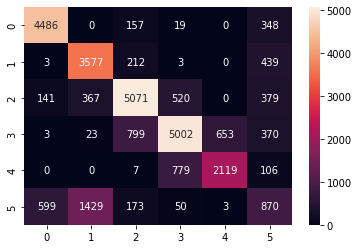

In [73]:
cf_matrix = confusion_matrix(all_pred_train['FINAL'], all_pred_train['ACTUAL'])
sns.heatmap(cf_matrix, annot=True, fmt='.0f')

In [74]:
f1_score(y_train, all_pred_train['FINAL'], average='macro')

0.7005033023260608

In [75]:
f1_score(y_test, all_pred_test['FINAL'], average='macro')

0.6743319949910905

# Prediction

The approach that led to the best model is **SMOTE - Multiclass RF**. So we will use this model to predict.

In [76]:
pred_df = pd.read_csv(os.path.join(DIR,'mwc22-client_table+-+test_x.csv'))

for col in pred_df.columns:
    try:
        pred_df[col] = pred_df[col].astype(np.float)
    except:
        pred_df[col] = pred_df[col].str.replace(',','.')
        pred_df[col] = pred_df[col].astype(float)

pred_df.head()

,CLIENT ID,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
0,48352078.0,8.33,100.00,0.0
1,18072186.0,93.42,186.83,1.0
2,48352246.0,45.83,137.50,0.0
3,18070621.0,16.67,200.00,1.0
4,48352262.0,13.33,160.00,0.0


The following steps have to be performed to perform a prediction:
- Correct format in numeric variables
- Clip maximum values of AVG CONSO and AVG BASKET SIZE
- Join orders data.
- Performing KNN Imputing 
- Add KMeans clusters information

In [77]:
pred_df['AVG CONSO'] = np.clip(pred_df['AVG CONSO'], a_max=1400, a_min=0)
pred_df['AVG BASKET SIZE'] = np.clip(pred_df['AVG BASKET SIZE'], a_max=1700, a_min=0)

In [78]:
pred_all_df = pd.merge( pred_df, clients_orders_summary, on='CLIENT ID', how='left')
pred_all_df.set_index('CLIENT ID',inplace=True)

In [79]:
if knn_imputing:
    print('Transforming started')
    X = pd.DataFrame(imputer.transform(pred_all_df), columns = selected_cols, index=pred_all_df.index)
    print('Transforming finished')
else:
    X = pd.DataFrame(X.fillna(-5))

Transforming started
Transforming finished


In [80]:
# Pre clustering with KMeans
X['pre_cluster'] = km.predict(X[cluster_cols])
#X = pd.merge( X, train_agg, on = ['pre_cluster'], how='left')
X

,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION,Apple_mean,Apricot_mean,Banana_mean,Blueberry_mean,Cheery_mean,Coconut_mean,Devil Fruit_mean,Grape_mean,Jackfruit_mean,Kiwi_mean,Lemon_mean,Lime_mean,Mango_mean,Melon_mean,Nectarine_mean,Nuwe Fruit_mean,Orange_mean,Papaya_mean,Pear_mean,Pineapple_mean,Plum_mean,Pomegranate_mean,Strawberry_mean,Watermelon_mean,n_orders,n_items_mean,n_items_sum,pre_cluster
CLIENT ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
48352078.0,8.33,100.00,0.0,0.000000,1.333333,1.000000,0.000000,1.000000,0.333333,0.666667,0.000000,0.000000,1.000000,2.333333,0.333333,0.000000,0.666667,1.000000,1.666667,1.333333,0.666667,1.333333,0.000000,0.000000,0.666667,1.000000,0.000000,7.666667,16.333333,126.666667,5
18072186.0,93.42,186.83,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,15.000000,30.000000,5
48352246.0,45.83,137.50,0.0,0.000000,0.666667,1.000000,0.333333,0.000000,0.333333,0.666667,0.000000,0.000000,1.333333,1.333333,0.333333,0.333333,0.333333,1.333333,1.333333,1.333333,0.333333,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,7.666667,11.666667,91.333333,5
18070621.0,16.67,200.00,1.0,0.666667,0.000000,2.333333,0.333333,4.000000,0.666667,0.333333,0.666667,0.000000,3.000000,1.666667,0.000000,1.000000,0.333333,3.666667,0.000000,2.666667,0.333333,1.666667,0.666667,1.000000,0.000000,0.000000,0.000000,9.000000,25.000000,236.666667,5
48352262.0,13.33,160.00,0.0,0.333333,1.666667,0.000000,0.000000,0.000000,0.333333,0.333333,0.333333,1.333333,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,1.666667,1.666667,0.000000,0.000000,0.333333,0.666667,0.000000,0.000000,0.333333,4.666667,9.666667,53.666667,5
48359553.0,16.67,200.00,0.0,0.000000,0.666667,1.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.333333,1.888889,0.000000,0.333333,0.000000,0.000000,0.000000,4.000000,0.888889,0.666667,0.000000,0.000000,0.888889,0.666667,0.111111,6.000000,12.777778,101.666667,5
18071647.0,8.33,100.00,1.0,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,3.333333,3.333333,0.000000,0.000000,0.000000,1.000000,3.333333,0.666667,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,2.666667,15.000000,41.666667,5
48359574.0,54.17,162.50,0.0,0.000000,0.000000,0.000000,0.000000,1.333333,0.000000,0.000000,0.000000,0.333333,0.666667,0.000000,9.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.666667,3.000000,13.333333,43.333333,5
48359627.0,26.67,106.67,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.333333,1.333333,3.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.333333,1.000000,0.000000,3.333333,10.333333,36.333333,5


In [83]:
selected_cols = X_train.columns
X = X[selected_cols]

In [84]:
y_final = smote_model.predict(X)
y_final

array([5., 1., 3., 4., 4., 3., 5., 3., 4., 6., 1., 1., 2., 5., 1., 6., 3.,
       1., 1.])

## Submision file

The final submision must be 2 columns: CLIENT ID and CLIENT_SEGMENT

In [85]:
submission = pd.DataFrame({'CLIENT ID': X.index, 'CLIENT_SEGMENT': y_final})
submission.to_csv('results.csv')